In [1]:
import numpy as np
import argparse
import torch
import os
import glob
import random
from evodiff.utils import Tokenizer
import pathlib
from sequence_models.datasets import UniRefDataset
from tqdm import tqdm
from evodiff.plot import aa_reconstruction_parity_plot
import pandas as pd
from evodiff.pretrained import CARP_38M, CARP_640M, D3PM_BLOSUM_38M, D3PM_BLOSUM_640M, D3PM_UNIFORM_38M, D3PM_UNIFORM_640M,\
                           OA_DM_640M, OA_DM_38M, LR_AR_38M, LR_AR_640M, ESM1b_650M
from matplotlib import pyplot as plt

home = str(pathlib.Path.home())

In [2]:
checkpoint = D3PM_BLOSUM_38M(return_all=True)
d3pm=True
model, collater, tokenizer, scheme, timestep, Q_bar, Q = checkpoint

torch.cuda.set_device(0)
device = torch.device('cuda:' + str(0))
model = model.eval().to(device)

exp


In [3]:
data = UniRefDataset('data/uniref50/', 'train', structure=False, max_len=2048)
data_valid = UniRefDataset('data/uniref50/', 'test', structure=False, max_len=2048)

In [4]:
def fwd_sample(seq, Q=Q, Q_bar=Q_bar, timestep=timestep):
    sample = torch.tensor(np.array([tokenizer.tokenize(s) for s in seq])[None, :, 0])
    sample = sample.to(torch.long)
    sample = sample.to(device)
    Q = Q.to(device)
    Q_bar = Q_bar.to(device)

    timesteps = timestep
    timesteps = torch.linspace(1, timesteps-1,int((timesteps-1)/1), dtype=int) # iterate over reverse timesteps
    timesteps = timesteps.to(device)
    
    trace = torch.zeros([timestep, len(sample), sample.shape[1]])
    trace[0] = sample
    with torch.no_grad():
        for t in tqdm(timesteps):
            timesteps = torch.tensor([t] * len(sample))
            timesteps = timesteps.to(device)
            x_tplus1 = sample.clone()
            for i, s in enumerate(sample):
                x_t_b = tokenizer.one_hot(s)
                p_theta_marg = torch.mm(x_t_b, Q[t])  # [P x K]
                p_theta_marg = p_theta_marg / p_theta_marg.sum(axis=1, keepdim=True)
                x_tplus1[i] = torch.multinomial(p_theta_marg, num_samples=1).squeeze()
            sample = x_tplus1
            trace[t] = sample
    diffs = (trace[1:] != trace[:-1]).cpu().numpy().mean(1)
    return diffs

In [5]:
# code gives same result as non-log version
def get_log_ps(d_pos):
    def lse_mvp(log_M, log_v):
        return torch.logsumexp(log_M + log_v, dim=-1)
    
    Q_ints = torch.log(Q[1:])
    log_I = torch.log(torch.eye(tokenizer.K, dtype=Q_ints.dtype) + 1e-60)
    log_1mI = torch.log(1 - torch.eye(tokenizer.K, dtype=Q_ints.dtype) + 1e-60)
    
    Q_hat = Q_ints[d_pos] + log_1mI
    
    taus = np.r_[np.argwhere(d_pos)[:, 0], [len(Q_ints)]]
    Ds = [Q_ints[:taus[0]].sum(0) + log_I if taus[0]>0 else I]
    for t_1, t_2 in zip(taus[:-1], taus[1:]):
        if t_2 == t_1 + 1:
            Ds.append(log_I)
        else:
            Ds.append(Q_ints[t_1+1:t_2].sum(0) +log_I)
    
    bwd_vec = torch.diag(Ds[-1])
    for Q_t, D in zip(Q_hat, Ds):
        bwd_vec = lse_mvp(D, lse_mvp(Q_t, bwd_vec))
    
    return bwd_vec

In [6]:
# diffs_fwd = [fwd_sample(data[1][0]) for fwd_sample(seq[0])
d= diffs_fwd[1].astype(bool)
d_pos = d[:, 0]
log_ps = get_log_ps(d_pos)

NameError: name 'diffs_fwd' is not defined

In [74]:
log_ps.shape

torch.Size([26])

In [128]:
N = 500
diffs_fwd = [fwd_sample(''.join(tokenizer.alphabet[:20])) for i in range(N)]

100%|███████████████████████████████████████| 499/499 [00:00<00:00, 2506.40it/s]


In [129]:
entropies = torch.zeros([20, 20])
for diffs in tqdm(diffs_fwd):
    for i, d in enumerate(diffs.T):
        entropies[i] += get_log_ps(d)[:20]
entropies = entropies / N

100%|█████████████████████████████████████████| 500/500 [00:36<00:00, 13.87it/s]


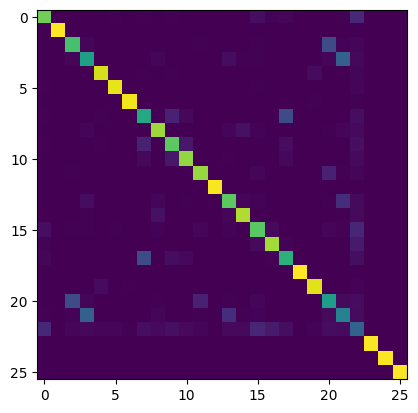

In [146]:
plt.imshow(Q[-1])

In [127]:
diffs_fwd[10].sum(0)

array([21.,  0., 32.,  8.,  8.,  0.,  1., 31., 12., 16., 29., 18., 28.,
        9., 22., 15., 30., 20.,  0.,  9.])

In [148]:
model(data[0])

TypeError: forward() missing 1 required positional argument: 'y'

In [20]:
 Q_bar[-1,:20, :20]

tensor([[0.0441, 0.0224, 0.0448, 0.0446, 0.0419, 0.0455, 0.0379, 0.0443, 0.0446,
         0.0443, 0.0444, 0.0447, 0.0342, 0.0446, 0.0447, 0.0442, 0.0443, 0.0443,
         0.0073, 0.0406],
        [0.0224, 0.6224, 0.0158, 0.0162, 0.0153, 0.0153, 0.0102, 0.0210, 0.0164,
         0.0210, 0.0204, 0.0158, 0.0091, 0.0163, 0.0163, 0.0195, 0.0198, 0.0211,
         0.0020, 0.0136],
        [0.0448, 0.0158, 0.0470, 0.0465, 0.0395, 0.0451, 0.0400, 0.0442, 0.0464,
         0.0441, 0.0443, 0.0470, 0.0326, 0.0464, 0.0464, 0.0453, 0.0451, 0.0442,
         0.0058, 0.0378],
        [0.0446, 0.0162, 0.0465, 0.0462, 0.0400, 0.0444, 0.0399, 0.0442, 0.0462,
         0.0442, 0.0444, 0.0465, 0.0337, 0.0461, 0.0462, 0.0451, 0.0450, 0.0443,
         0.0061, 0.0384],
        [0.0419, 0.0153, 0.0395, 0.0400, 0.0691, 0.0375, 0.0439, 0.0449, 0.0401,
         0.0450, 0.0448, 0.0395, 0.0241, 0.0402, 0.0401, 0.0413, 0.0419, 0.0446,
         0.0213, 0.0754],
        [0.0455, 0.0153, 0.0451, 0.0444, 0.0375, 0.0828, 0.0

In [19]:
(2 ** Q_bar[-1,:20, :20])

tensor([[1.0310, 1.0157, 1.0315, 1.0314, 1.0294, 1.0321, 1.0266, 1.0312, 1.0314,
         1.0312, 1.0313, 1.0315, 1.0240, 1.0314, 1.0314, 1.0311, 1.0312, 1.0312,
         1.0051, 1.0285],
        [1.0157, 1.5394, 1.0110, 1.0113, 1.0107, 1.0106, 1.0071, 1.0147, 1.0114,
         1.0146, 1.0143, 1.0110, 1.0063, 1.0114, 1.0113, 1.0136, 1.0138, 1.0147,
         1.0014, 1.0095],
        [1.0315, 1.0110, 1.0331, 1.0328, 1.0277, 1.0317, 1.0281, 1.0311, 1.0327,
         1.0311, 1.0312, 1.0331, 1.0228, 1.0327, 1.0327, 1.0319, 1.0318, 1.0311,
         1.0040, 1.0266],
        [1.0314, 1.0113, 1.0328, 1.0326, 1.0281, 1.0313, 1.0281, 1.0311, 1.0325,
         1.0311, 1.0312, 1.0327, 1.0236, 1.0325, 1.0326, 1.0317, 1.0317, 1.0312,
         1.0043, 1.0270],
        [1.0294, 1.0107, 1.0277, 1.0281, 1.0491, 1.0263, 1.0309, 1.0316, 1.0282,
         1.0317, 1.0315, 1.0278, 1.0168, 1.0282, 1.0282, 1.0291, 1.0295, 1.0314,
         1.0149, 1.0537],
        [1.0321, 1.0106, 1.0317, 1.0313, 1.0263, 1.0590, 1.0

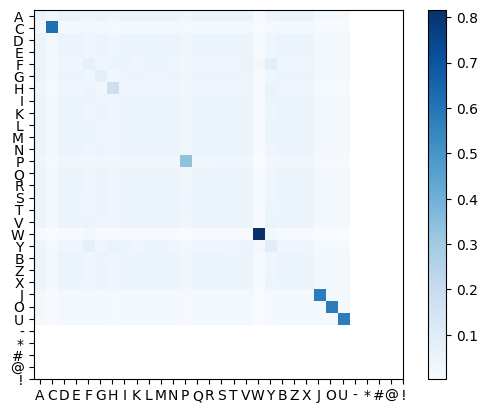

In [10]:
a = tokenizer.alphabet

plt.imshow(Q_bar[-1,], cmap="Blues")
plt.xticks(np.arange(len(a)), a)
plt.yticks(np.arange(len(a)), a);
plt.colorbar()

In [9]:
(np.log(1/26) - np.log(Q_bar[-1])).mean(-1)

tensor([0.0664, 0.8972, 0.0888, 0.0847, 0.0784, 0.1061, 0.1995, 0.0671, 0.0835,
        0.0664, 0.0679, 0.0892, 0.3846, 0.0833, 0.0840, 0.0712, 0.0704, 0.0673,
        1.6529, 0.0954, 0.0869, 0.0838, 0.0633, 0.7566, 0.7566, 0.7566],
       dtype=torch.float64)

In [130]:
true_entropies = torch.diag(entropies)
kls = true_entropies[:, None] - entropies

In [131]:
kls.min()

tensor(-3.1519)

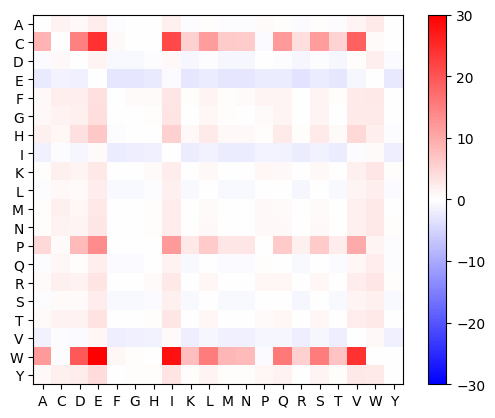

In [150]:
b = 30
a = tokenizer.alphabet[:20]
plt.imshow(kls, vmax=b, vmin=-b, cmap='bwr')
plt.xticks(np.arange(20), a)
plt.yticks(np.arange(20), a);
plt.colorbar()

# extra code

In [104]:
# # nonlog version of code
# Q_ints = Q[1:]
# I = torch.eye(tokenizer.K, dtype=Q_ints.dtype)


# Q_hat = Q_ints[d_pos] * (1 - I)

# taus = np.r_[np.argwhere(d_pos)[:, 0], [len(Q_ints)]]
# Ds = [Q_ints[:t_1].prod(0) * I if t_1>0 else I]
# for t_1, t_2 in zip(taus[:-1], taus[1:]):
#     if t_2 == t_1 + 1:
#         Ds.append(I)
#     else:
#         Ds.append(Q_ints[t_1+1:t_2].prod(0) * I)

# bwd_vec = Ds[-1].sum(-1)
# for Q_t, D in zip(Q_hat, Ds):
#     bwd_vec = D @ (Q_t @ bwd_vec)

# print(bwd_vec)

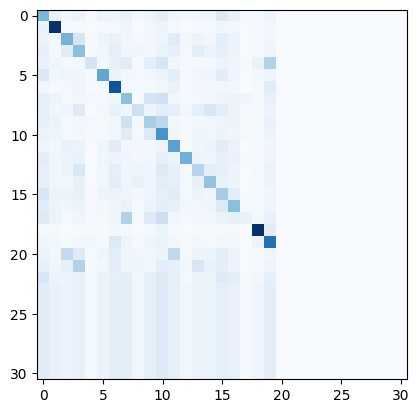

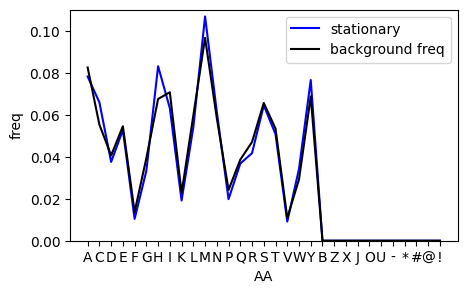